# this notebook tries to validate the model with GITT - contact resistance =8e-3 get the best fit!

In [1]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing;import pandas as pd;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [3]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
# BasicPath = "C:/Users/rl1120/OneDrive - Imperial College London/"  #
BasicPath= "D:/OneDrive - Imperial College London/SimDataSave/P3R13/Validation/"
Target  = 'GITT_2C_v1/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [4]:
# define parameter of double and single 
Para_dict_Same = {
   ################################# Same for single and double:
   "Mesh list":[ [5,5,5,60,30], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   # solvent diffusion parameters:
   "EC initial concentration in electrolyte [mol.m-3]":[3500],
   "Typical EC concentration [mol.m-3]":[3500,],

   "Negative electrode porosity":[0.25],
   "SEI resistivity [Ohm.m]":[2e5,],
   "Initial inner SEI thickness [m]":[1.2362e-08,],
   "Initial outer SEI thickness [m]":[2.5e-9,],
   "Contact resistance [Ohm]":[8e-3],
   #"Initial Neg SOC":[0.93,0.87],
}

Para_dict_DD_ONLY = {
     "Model option":[{
      "SEI": "constant",
      "SEI porosity change": "true",
      #"SEI on cracks": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  
      },],
     ################################# Need to be different between single and double:
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10",], # "Cross_diffusivity_1p5E_12",
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dcEC": ["dLJP_Two_Species_dco_Jung2023",],
     "Measured dLJP_dce": ["dLJP_Two_Species_dce_Jung2023",],
}
Para_dict_SD_ONLY = {
     "Model option":[{
      "SEI": "constant",
      "SEI porosity change": "true",
      #"SEI on cracks": "true",
      "solvent diffusion": "single no consume wo refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",
      },],
     ################################# fake, must have only one option
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10",],
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dce":["dLJP_One_Specie_dce_Jung2023",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

1 1


In [5]:
# import experimental GITT data from file
BasicPath = "D:/OneDrive - Imperial College London/SimDataSave/InputData/"
Target = "GITT/"
GITT_data = pd.read_csv(
    BasicPath + Target + "2C_GITT_25deg_Niall.csv", comment="#", header=None
).to_numpy()
t_exp = GITT_data[:,0]/3600
I_exp = -GITT_data[:,3]/1000
V_exp = GITT_data[:,2]
#Q_exp = GITT_data[:,1]/1000
Q_exp = []
for i in range (len(t_exp)):
    Q_temp = np.trapz(I_exp[0:i],t_exp[0:i])
    Q_exp.append(Q_temp)

In [6]:
def Scan_GITT(index_i,Para_dd_i):
    print('Start Now! Scan %d.' % index_i)  
    CyclePack,para_used = Para_init_Dict(Para_dd_i)
    [Mesh_list,model_options] = CyclePack
    model = pybamm.lithium_ion.DFN(options=model_options)
    exp = pybamm.Experiment([(
        "Rest for 60 seconds (1 second period)", 
        "Discharge at 2C for 72 seconds or until 2.5V (0.1 second period)", 
        "Rest for 1 hour (1 second period)")] * 25,)
    var_pts = {
        "x_n": Mesh_list[0],  # negative electrode
        "x_s": Mesh_list[1],  # separator 
        "x_p": Mesh_list[2],  # positive electrode
        "r_n": Mesh_list[3],  # negative particle
        "r_p": Mesh_list[4],  # positive particle
    }
    sim    = pybamm.Simulation(
        model, experiment = exp,
        parameter_values = para_used,
        #solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
        )       
    sol    = sim.solve()
    t_seconds = sol["Time [s]"].entries
    t_hours = (t_seconds - 60) / 3600
    I = sol["Current [A]"].entries
    Q = sol["Discharge capacity [A.h]"].entries
    V = sol["Terminal voltage [V]"].entries
    print(sol["Negative electrode porosity"].entries[0,-1])
    print(sol["Negative electrode porosity"].entries[0,0])
    # No zoom in:
    fig, ax = plt.subplots()
    ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')
    ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Simulation')
    
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Terminal voltage [V]')
    ax.set_title('25x1C pulses at 298K, comparison')
    ax.legend(loc='best',frameon=False)
    fig.suptitle(f'Scan = {index_i}')
    plt.show()
    plt.savefig(
        BasicPath + Target + 
        f'Scan = {index_i}_GITT_1C_discharge_298K.png',dpi=600)
    return sol

Start Now! Scan 1.


At t = 0.00455149, , mxstep steps taken before reaching tout.
At t = 0.00455149, , mxstep steps taken before reaching tout.
At t = 0.00205707, , mxstep steps taken before reaching tout.
At t = 0.00205707, , mxstep steps taken before reaching tout.
At t = 0.00205707, , mxstep steps taken before reaching tout.
At t = 0.00319075, , mxstep steps taken before reaching tout.
At t = 0.00319075, , mxstep steps taken before reaching tout.
At t = 0.0024988, , mxstep steps taken before reaching tout.
At t = 0.0024988, , mxstep steps taken before reaching tout.


0.24429360068259387
0.24429360068259387


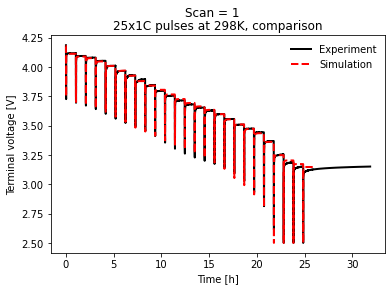

<Figure size 432x288 with 0 Axes>

In [7]:
# for DD first:
Index_DD = np.arange(1,len(Para_DD)+1).tolist()  
Index_SD = np.arange(1,len(Para_SD)+1).tolist()  
# scan: DD and SD respectively 
DD_Dis_All = []; SD_Dis_All = [];  
for Para_dd_i,index_i in zip(Para_DD,Index_DD):
    DD_Dis_All.append(  Scan_GITT(index_i, Para_dd_i)  )

for Para_sd_i,index_i in zip(Para_SD,Index_SD):
    SD_Dis_All.append(  Scan_GITT(index_i, Para_sd_i)  )

Start Now! Scan 1.


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0.00454, , mxstep steps taken before reaching tout.
At t = 0.00454, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0.00204559 and h = 3.99364e-023, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00204559, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0.00204559, , mxstep steps taken before reaching tout.
At t = 0.00318223, , mxstep steps taken before reaching tout.
At t = 0.00318223, , mxstep steps taken before reaching tout.
At t = 0.00249235, , mxstep steps taken before reaching tout.
At

0.24429360068259387
0.24429360068259387


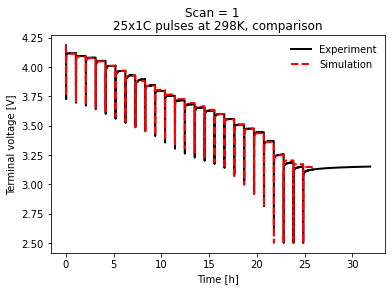

<Figure size 432x288 with 0 Axes>

In [8]:
SD_Dis_All.append(  Scan_GITT(1, Para_SD[0])  )

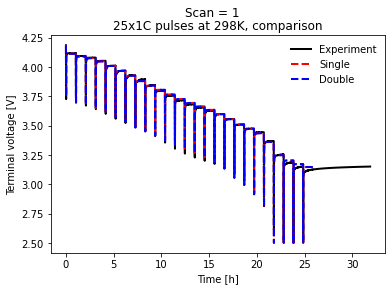

In [10]:
# No zoom in:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')

sol_sd = SD_Dis_All[0]
t_seconds = sol_sd["Time [s]"].entries
t_hours = (t_seconds - 60) / 3600
I = sol_sd["Current [A]"].entries
Q = sol_sd["Discharge capacity [A.h]"].entries
V = sol_sd["Terminal voltage [V]"].entries
ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Single')

sol_dd = DD_Dis_All[0]
t_seconds = sol_dd["Time [s]"].entries
t_hours = (t_seconds - 60) / 3600
I = sol_dd["Current [A]"].entries
Q = sol_dd["Discharge capacity [A.h]"].entries
V = sol_dd["Terminal voltage [V]"].entries
ax.plot(t_hours,V,color='b',linewidth=2,  linestyle='--',label='Double')

ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('25x1C pulses at 298K, comparison')
ax.legend(loc='best',frameon=False)
fig.suptitle(f'Scan = {index_i}')
plt.show()

0.24429360068259387
0.24429360068259387


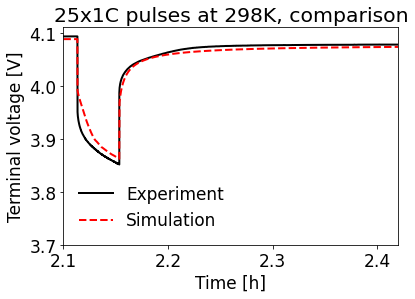

In [56]:
sol = DD_Dis_All[0]
t_seconds = sol["Time [s]"].entries
t_hours = (t_seconds - 60) / 3600
I = sol["Current [A]"].entries
Q = sol["Discharge capacity [A.h]"].entries
V = sol["Terminal voltage [V]"].entries
print(sol["Negative electrode porosity"].entries[0,-1])
print(sol["Negative electrode porosity"].entries[0,0])
# No zoom in:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')
ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title(f'25x1C pulses at 298K, comparison')
ax.legend(loc='best',frameon=False)
plt.xlim(2.1,2.42)
plt.ylim(3.7,4.11)
plt.show()

0.24429360068259387
0.24429360068259387


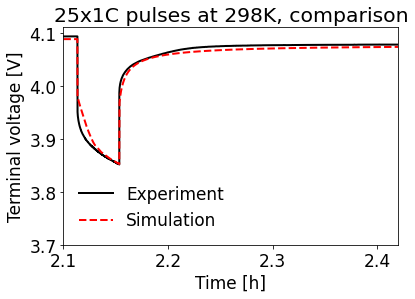

In [57]:
sol = DD_Dis_All[1]
t_seconds = sol["Time [s]"].entries
t_hours = (t_seconds - 60) / 3600
I = sol["Current [A]"].entries
Q = sol["Discharge capacity [A.h]"].entries
V = sol["Terminal voltage [V]"].entries
print(sol["Negative electrode porosity"].entries[0,-1])
print(sol["Negative electrode porosity"].entries[0,0])
# No zoom in:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')
ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title(f'25x1C pulses at 298K, comparison')
ax.legend(loc='best',frameon=False)
plt.xlim(2.1,2.42)
plt.ylim(3.7,4.11)
plt.show()

0.24429360068259387
0.24429360068259387


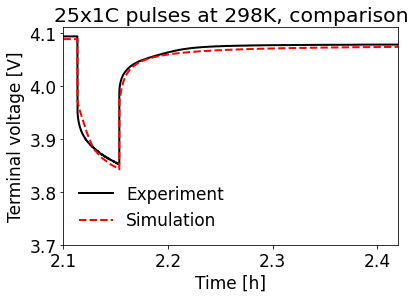

In [58]:
sol = DD_Dis_All[2]
t_seconds = sol["Time [s]"].entries
t_hours = (t_seconds - 60) / 3600
I = sol["Current [A]"].entries
Q = sol["Discharge capacity [A.h]"].entries
V = sol["Terminal voltage [V]"].entries
print(sol["Negative electrode porosity"].entries[0,-1])
print(sol["Negative electrode porosity"].entries[0,0])
# No zoom in:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')
ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title(f'25x1C pulses at 298K, comparison')
ax.legend(loc='best',frameon=False)
plt.xlim(2.1,2.42)
plt.ylim(3.7,4.11)
plt.show()

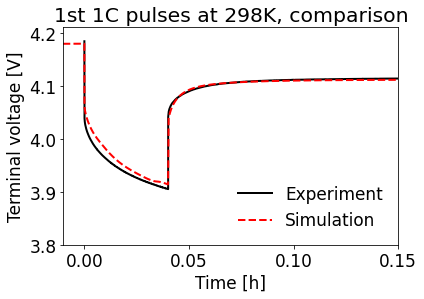

In [59]:
# No zoom in:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')
ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title(f'1st 1C pulses at 298K, comparison')
ax.legend(loc='best',frameon=False)
plt.xlim(-0.01,0.15)
plt.ylim(3.8,4.21)
plt.show()

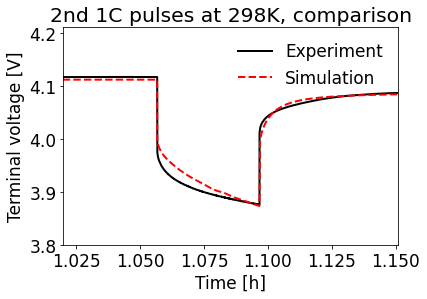

In [60]:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')
ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('2nd 1C pulses at 298K, comparison')
ax.legend(loc='best',frameon=False)
plt.xlim(1.02,1.151)
plt.ylim(3.8,4.21)
plt.show()

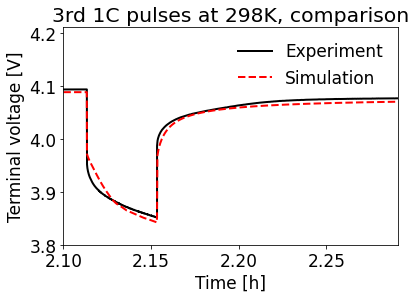

In [61]:
# No zoom in:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')
ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('3rd 1C pulses at 298K, comparison')
ax.legend(loc='best',frameon=False)
plt.xlim(2.10,2.291)
plt.ylim(3.8,4.21)
plt.show()

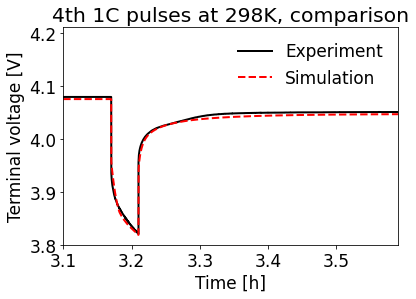

In [62]:
# No zoom in:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,color='k',linewidth=2,  linestyle='-',label='Experiment')
ax.plot(t_hours,V,color='r',linewidth=2,  linestyle='--',label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('4th 1C pulses at 298K, comparison')
ax.legend(loc='best',frameon=False)
plt.xlim(3.10,3.591)
plt.ylim(3.8,4.21)
plt.show()

In [63]:
label = ["Double","Single"] 
var = [
    "Battery voltage [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
quick_plot = pybamm.QuickPlot(
    [DD_Dis_All[0],SD_Dis_All[0],], var,label,variable_limits='fixed',
    time_unit='hours',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=26.350773205014367, step=0.26350773205014366…